<center>

#     
### NATURAL LANGUAGE PROCESSING
## 2023./2024.
# Word Embeddings
## Data: hrWaC, ParlaSent
#### Nika Hell i Josipa Radak      

<img src="https://drive.google.com/uc?export=view&id=1UPCuQH-9tGKaR1I0jByo9Z08654SfN0Q" width="600" height="600">


</center>



<center>

#       

# What is word embedding?
Word embeddings are a representation of words as real-valued vectors, where words with similar meanings have similar vector representations. This technique is used in natural language processing (NLP) to analyze text data. Word embeddings are learned using various methods, such as neural networks, dimensionality reduction on the word co-occurrence matrix, probabilistic models, and explicit representation in terms of context. Word embeddings can be trained jointly with a neural network model or as an unsupervised process using document statistics. They are also used to reduce the dimensionality of text data, making it more computationally efficient for machine learning models.

#Types of word ebeddings

Word embeddings can be categorized into several types based on their learning methods and characteristics. Some of the most popular word embedding techniques include:

</center>

1.  **Frequency-based embeddings**: These methods utilize the frequency of words to generate their vector representations. Examples include CountVectorizer and TF-IDF.
2.  **Prediction-based embeddings**: These methods learn to predict words from their neighboring words in sentences. Examples include Word2Vec and GloVe.
3. **Neural network-based embedding**s: These methods use neural networks to learn word embeddings. Examples include Word2Vec and GloVe.
4. **Matrix factorization-based embeddings**: These methods use matrix factorization techniques to learn word embeddings. Examples include GloVe.
5. **Context-based embeddings**: These methods consider the entire sentence or context when learning word embeddings. Examples include BERT and ELMo.
6. **Subword-based embeddings**: These methods take into account subword information, which can improve the representation of rare words and words with misspellings. Examples include FastText.

**Content of the notebook**

> Libraries

> Connecting to Google Drive

> Helper functions

> Model

>> GloVe (Global Vectors for Word Representation)

>>> Load the data

>>> Model train

>>>> Classes

>>>> Train

## Libraries

In [ ]:
import numpy as np  # import NumPy for scientific computing
import os  # import the os module for operating system functionalities
import pandas as pd  # import Pandas for data manipulation and analysis
import csv  # import the csv module for reading and writing CSV files

import matplotlib.pyplot as plt  # import pyplot module for creating visualizations
import seaborn as sns  # import Seaborn for statistical data visualization

from collections import defaultdict  # import defaultdict for handling missing keys

import pickle  # import pickle for serializing and deserializing Python objects

from argparse import Namespace # the namespace class is used to create an object that holds attributes corresponding to command-line arguments

from nltk import ngrams # imports the ngrams function from the Natural Language Toolkit (NLTK), which is used for generating n-grams
from tqdm import tqdm # imports the tqdm library, which provides a progress bar for loops

import torch  # import the PyTorch library for tensor operations and neural network functionalities
import torch.nn as nn  # import the nn module from PyTorch for building neural network layers and architectures
import torch.nn.functional as F  # import the functional interface of PyTorch for neural network operations
import torch.optim as optim  # import the optim module from PyTorch for optimization algorithms such as SGD, Adam, etc.
from torch.utils.data import Dataset, DataLoader  # import Dataset and DataLoader for handling data loading in PyTorch
from torch.nn.utils.rnn import pad_sequence  # import pad_sequence function for padding variable-length sequences
from torch.optim.lr_scheduler import ReduceLROnPlateau  # import ReduceLROnPlateau for adjusting learning rate during training
from torch.nn.functional import cross_entropy  # import cross_entropy function for calculating cross-entropy loss

from itertools import chain  # import chain function for flattening nested lists

import gc # garbage collector

## Connecting to Google Drive

In [ ]:
# Importing the drive module from the google.colab library
from google.colab import drive
# Mounting the Google Drive to the '/content/drive' directory
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the current working directory
%cd /content/drive/MyDrive/nlp_project/

/content/drive/.shortcut-targets-by-id/1dadLNnejsKWL1qhI8AmHtxjCR430s42m/nlp_project


In [ ]:
from nlp import StepByStep, Vectorizer, Vocabulary # import helpers from nlp.py script

## Helper functions

In [ ]:
# attempts to open a specified file in binary write mode
# uses the pickle module to serialize and save the input vocabulary to the file
# prints a success message if the vocabulary is successfully saved
# handles exceptions, such as writing errors, and prints detailed error messages
def save_serialized_object(data, filename='serialized_data.pkl'):
  # attempt to open the specified file in binary write ('wb') mode
  try:
    with open(filename, 'wb') as file:
      # use the pickle module to serialize and save the data to the file
      pickle.dump(data, file)
    # print a success message indicating that the data has been saved to the file
    print(f"Data has been saved to the file: {filename}")
  # handle exceptions, such as writing errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error saving data to '{filename}': {e}")

In [ ]:
# attempts to open a specified file in binary read mode
# uses the pickle module to deserialize and load the vocabulary from the file
# returns the loaded vocabulary
# handles the case where the file is not found or encounters reading errors, printing appropriate error messages
def load_serialized_object(filename='serialized_data.pkl'):
  # attempt to open the specified file in binary read ('rb') mode
  try:
    with open(filename, 'rb') as file:
      # use the pickle module to deserialize and load the data from the file
      loaded_data = pickle.load(file)
    # return the loaded data
    return loaded_data
  # handle the case where the file is not found
  except FileNotFoundError:
    # print an error message indicating that the file was not found
    print(f"Error: File '{filename}' not found.")
    # return None to signify the absence of data
    return None
  # handle other exceptions, such as reading errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error loading data from '{filename}': {e}")
    # return None to signify the inability to load the data
    return None

In [ ]:
def write_to_csv_glove(epoch, cbow_training_update, file_name):
  # open the CSV file in append mode, ensuring no newlines are added between rows
  with open(file_name, mode='a', newline='') as file:
    # create a CSV writer object
    writer = csv.writer(file)
    # write a row to the CSV file containing epoch and cbow_training_update
    writer.writerow([epoch, cbow_training_update])

In [ ]:
# function definition for saving and loading a checkpoint
def save_checkpoint_g(model, optimizer, epoch, train_loss, filename):
  # save the model state as a checkpoint
  checkpoint = {
      'epoch': epoch, # save last epoch
      'model_state_dict': model.state_dict(), # save models state
      'optimizer_state_dict': optimizer.state_dict(), # save models optimizer state
      'train_loss': train_loss, # save train loss
  }
  torch.save(checkpoint, filename)

In [ ]:
# function definition for loading a checkpoint
def load_checkpoint_g(model, optimizer, filename):
  # check the availability of GPU and set the appropriate device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # check if the checkpoint file exists
  if os.path.exists(filename):
    # if the file exists, load the checkpoint
    checkpoint = torch.load(filename)
    # load model's state, optimizer's state, epoch, and train loss from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    # print information about the loaded checkpoint
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {train_loss}")
    # move the model to the appropriate device
    model.to(device)
    # return the loaded model, optimizer, epoch, and train loss
    return model, optimizer, epoch,  train_loss
  # if the file doesn't exist, raise a FileNotFoundError
  else:
    raise FileNotFoundError("Checkpoint file does not exist.")

In [ ]:
def plot_progress_from_csv(filename):
  data = pd.read_csv(filename, header=None, names=['Epoch', 'Loss'])

  # Plot the graph
  plt.plot(data['Epoch'], data['Loss'], marker='o', linestyle='-')
  plt.xlabel('Epoch')  # Label for the x-axis
  plt.ylabel('Loss')   # Label for the y-axis
  plt.title('Loss Plot over Epochs')  # Title of the plot
  plt.grid(True)       # Enable gridlines
  plt.show();          # Show the plot

## Model

### GloVe (Global Vectors for Word Representation)



GloVe is an unsupervised learning algorithm used to obtain vector representations for words. It is a model architecture that learns word embeddings by leveraging global co-occurrence statistics to represent words as vectors. GloVe is trained on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. GloVe is similar to Word2Vec in that it produces word embeddings, but it uses a different approach based on matrix factorization techniques.

![img](https://nlp.stanford.edu/projects/glove/images/man_woman.jpg)

### Load the data

In [ ]:
# change the current working directory
%cd /content/drive/MyDrive/nlp_project/GloVe

/content/drive/.shortcut-targets-by-id/1dadLNnejsKWL1qhI8AmHtxjCR430s42m/nlp_project/GloVe


In [ ]:
args = Namespace(
    vocabulary="/content/drive/MyDrive/nlp_project/preprocessing_glove/glove_vocab.pkl",  # path to the file where the vocabulary is saved
    co_occurrence_matrix='/content/drive/MyDrive/nlp_project/preprocessing_glove/co_occurrence_matrix.pkl',  # path to the file where the co-occurrence matrix is saved

    batch_size=1024,  # size of the subset of data to be used for training
    lr=0.001,
    embedding_dim = 200,
)

In [ ]:
args_glove1 = Namespace(
    num_epochs = 15, # number of epochs for training the model
    update='glove_training_update.csv',
    checkpoint_path="glove_checkpoint.pth",  # path to the checkpoint of the CBOW model
)

In [ ]:
co_occurrence_matrix=load_serialized_object(args.co_occurrence_matrix) # load co-occurrence matrix

In [ ]:
glove_vocab=load_serialized_object(args.vocabulary) # laod glove vocabulary

### Model train

#### Classes

In [ ]:
class GloveModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    """
    Initialize the Glove model.
    Args:
        vocab_size (int): Size of the vocabulary.
        embedding_dim (int): Dimensionality of word embeddings.
    """
    super(GloveModel, self).__init__()
    # define embedding layers for target and context words
    self.embedding_target = nn.Embedding(vocab_size, embedding_dim)
    self.embedding_context = nn.Embedding(vocab_size, embedding_dim)
    # define bias embeddings for target and context words
    self.bias_target = nn.Embedding(vocab_size, 1)
    self.bias_context = nn.Embedding(vocab_size, 1)

  def forward(self, target, context):
    """
    Forward pass of the Glove model.
    Args:
        target (torch.Tensor): Indices of target words.
        context (torch.Tensor): Indices of context words.
    Returns:
        torch.Tensor: The result of the forward pass.
    """
    # embed target and context words
    emb_target = self.embedding_target(target)
    emb_context = self.embedding_context(context)
    # get bias embeddings for target and context words
    bias_target = self.bias_target(target).squeeze(1)
    bias_context = self.bias_context(context).squeeze(1)
    # compute dot product between target and context word embeddings
    dot_product = torch.sum(emb_target * emb_context, dim=1)
    # return the sum of dot product and biases
    return dot_product + bias_target + bias_context

  def cosine_similarity(self, embedding1, embedding2):
    """
    Calculate cosine similarity between two embeddings.
    Args:
        embedding1 (torch.Tensor): Embedding of the first vector.
        embedding2 (torch.Tensor): Embedding of the second vector.
    Returns:
        torch.Tensor: Cosine similarity between the two embeddings.
    """
    # normalize embeddings
    embedding1_norm = F.normalize(embedding1, p=2, dim=-1)
    embedding2_norm = F.normalize(embedding2, p=2, dim=-1)
    # calculate dot product
    dot_product = torch.sum(embedding1_norm * embedding2_norm, dim=-1)
    return dot_product

In [ ]:
class GloveTrainer:
    def __init__(self, model, optimizer, loss_fn, glove_vocab, co_occurrence_matrix, start_epoch,  args, specific_args):
      """
        Initializes the GloveTrainer object.

        Args:
            model (torch.nn.Module): The Glove model.
            optimizer (torch.optim.Optimizer): The optimizer for training.
            loss_fn: The loss function for training.
            glove_vocab: The Glove vocabulary.
            co_occurrence_matrix: The co-occurrence matrix.
            start_epoch (int): The starting epoch for training.
            args: Additional arguments.
      """
      self.model = model
      self.optimizer = optimizer
      self.loss_fn = loss_fn
      self.glove_vocab = glove_vocab
      self.co_occurrence_matrix = co_occurrence_matrix
      self.args = args
      self.specific_args = specific_args
      self.start_epoch = start_epoch
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      self.model.to(self.device)

    def train(self):
      """
        Trains the Glove model for multiple epochs.
      """
      # calculate total number of batches
      total_batches = len(self.co_occurrence_matrix) // self.args.batch_size
      # iterate over epochs
      for epoch in range(self.start_epoch, self.specific_args.num_epochs):
        print(f"Training epoch: {epoch}")
        # train model for current epoch
        train_loss = self.train_model(self.co_occurrence_matrix,total_batches)
        # save checkpoint and write to CSV
        self.save_checkpoint(epoch, train_loss)

    def save_checkpoint(self, epoch, train_loss):
      """
        Saves a checkpoint after each epoch of training.

        Args:
            epoch (int): The current epoch.
            train_loss: The training loss of the current epoch.
      """
      # save the checkpoint for later use
      save_checkpoint_g(self.model, self.optimizer, epoch,  train_loss, self.specific_args.checkpoint_path)
      # print state
      print(f"Epoch: {epoch}, Training Loss: {train_loss}")
      # wtite loss and epoch to csv file
      write_to_csv_glove(epoch, train_loss, self.specific_args.update)

    def train_model(self, train_loader, total_batches):
      """
        Trains the model using the provided data loader.

        Args:
            train_loader: DataLoader for training data.
            total_batches (int): Total number of batches.

        Returns:
            mean_train_loss: Mean training loss for the epoch.
      """
      # set model to training mode
      self.model.train()

      # initialize an empty list to store individual batch losses
      train_losses = []

      # shuffle keys of co-occurrence matrix
      keys = list(self.co_occurrence_matrix.keys())
      np.random.shuffle(keys)

      # initialize tqdm
      progress_bar = tqdm(total=total_batches, desc='Training Progress', unit='batch')

      # iterate over batches
      for i in range(0, len(keys), self.args.batch_size):
        batch_keys = keys[i:i + self.args.batch_size]
        batch_targets = []
        batch_contexts = []
        # construct batch data for targets and contexts
        for target_idx in batch_keys:
          for context_idx, co_occurrence_count in self.co_occurrence_matrix[target_idx].items():
            batch_targets.append(target_idx)
            batch_contexts.append(context_idx)

        # move batch data to the same device as the model
        batch_targets = torch.tensor(batch_targets).to(self.device)
        batch_contexts = torch.tensor(batch_contexts).to(self.device)

        # zero the gradients
        self.optimizer.zero_grad()

        # forward pass
        logits = self.model(batch_targets, batch_contexts)

        # prepare targets (ones)
        targets = torch.ones_like(logits)

        # calculate loss
        loss = self.loss_fn(logits, targets)

        # backward pass
        loss.backward()

        # update parameters
        self.optimizer.step()
        train_losses.append(loss.item())
        progress_bar.update(1)  # update progress bar

      progress_bar.close()  # close tqdm
      mean_train_loss = sum(train_losses) / len(train_losses)
      return mean_train_loss

#### Train

In [ ]:
# initialize the GloveModel with the specified vocabulary size and embedding dimension
model = GloveModel(len(glove_vocab), embedding_dim = args.embedding_dim)

# define the loss function to be Binary Cross Entropy (BCE)
loss_fn =  nn.BCEWithLogitsLoss()
# Initialize the Adam optimizer with a learning rate,
# optimizing the parameters of the model
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# initialize a learning rate scheduler to adjust the learning rate during training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',  # adjust LR based on loss reduction
                                                 factor=0.5,  # factor by which LR is reduced
                                                 patience=1)  # number of epochs to wait before LR reduction


In [ ]:
if os.path.exists(args_glove1.checkpoint_path):
  # load existing model weights and file subset information
  model, optimizer, start_epoch, start_loss = load_checkpoint_g(model, optimizer, args_glove1.checkpoint_path)
  start_epoch = start_epoch+1
  print("Previously saved model weights loaded.")
else:
  # previously saved model weights do not exist. Initializing model
  print("Previously saved model weights do not exist. Initializing model.")
  start_epoch = 0
  start_loss = float('inf')


Previously saved model weights do not exist. Initializing model.


In [ ]:
trainer = GloveTrainer(model=model, optimizer=optimizer,
                       loss_fn=loss_fn, glove_vocab=glove_vocab,
                       co_occurrence_matrix=co_occurrence_matrix,
                       start_epoch=start_epoch, args=args,
                       specific_args=args_glove1)
# start training
trainer.train()

Training epoch: 0


Training Progress: 846batch [01:59,  7.08batch/s]


Epoch: 0, Training Loss: 5.410545223429975
Training epoch: 1


Training Progress: 846batch [01:58,  7.12batch/s]


Epoch: 1, Training Loss: 4.43469352586895
Training epoch: 2


Training Progress: 846batch [01:58,  7.13batch/s]


Epoch: 2, Training Loss: 3.557295979901127
Training epoch: 3


Training Progress: 846batch [01:58,  7.11batch/s]


Epoch: 3, Training Loss: 2.836673588899292
Training epoch: 4


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 4, Training Loss: 2.2524505036378866
Training epoch: 5


Training Progress: 846batch [01:58,  7.15batch/s]


Epoch: 5, Training Loss: 1.777289300241087
Training epoch: 6


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 6, Training Loss: 1.383969450250585
Training epoch: 7


Training Progress: 846batch [01:58,  7.15batch/s]


Epoch: 7, Training Loss: 1.0602775910081028
Training epoch: 8


Training Progress: 846batch [01:58,  7.13batch/s]


Epoch: 8, Training Loss: 0.7961128840914291
Training epoch: 9


Training Progress: 846batch [01:58,  7.13batch/s]


Epoch: 9, Training Loss: 0.5829357327651189
Training epoch: 10


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 10, Training Loss: 0.41361903082183066
Training epoch: 11


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 11, Training Loss: 0.28460741888546776
Training epoch: 12


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 12, Training Loss: 0.18777279193836746
Training epoch: 13


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 13, Training Loss: 0.11961488489581197
Training epoch: 14


Training Progress: 846batch [01:58,  7.14batch/s]


Epoch: 14, Training Loss: 0.07330578178096889


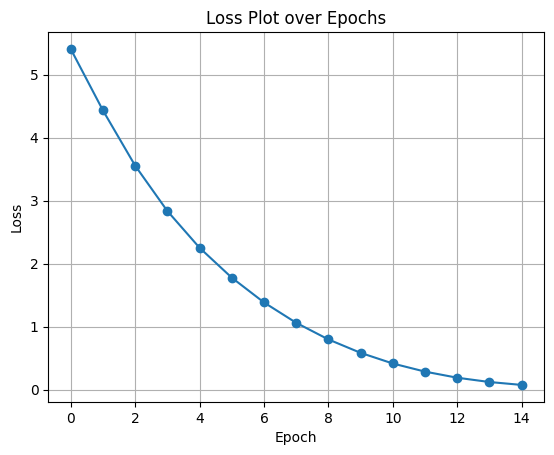

In [ ]:
plot_progress_from_csv(args_glove1.update) #Visualize training loss over epochs in Glove model training

The training process for the GloVe model demonstrates consistent improvement over multiple epochs. The decreasing trend in training loss from the initial epoch to the final epoch indicates that the model is effectively learning and refining its embeddings. The stability in training progress and time per epoch suggests that the training process is reliable and consistent. Overall, the observed decrease in training loss and stable training process indicate successful training of the Glove model, resulting in meaningful representations of the input data.